In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage
import cv2
from skimage import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vgg16 = torch.load('../../../../Data/Pytorch Trained Models/vgg16.pth')
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [3]:
# Get size of 43 layer
x = torch.rand(1, 3, 224, 224)
for i in range(31):
    x = vgg16.features[i](x)
x.size()

torch.Size([1, 512, 7, 7])

In [4]:
# Store the weight values
state_dict = vgg16.state_dict()

In [2]:
class DeepLab(nn.Module):
    def __init__(self, out_dim=21):
        super(DeepLab, self).__init__()
        self.module1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        self.module2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.module3 = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=1, stride=1, padding=0, dilation=4),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(4096, 4096, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(4096, out_dim, kernel_size=1, stride=1)
        )
        
    def forward(self, x):
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
#         x = F.interpolate(x, size=(224), mode='bilinear', align_corners=False)
        return x
    
model = DeepLab()
model

DeepLab(
  (module1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Con

In [6]:
x = torch.rand(1, 3, 224, 224)
output = model(x)
output.size()

torch.Size([1, 21, 28, 28])

In [7]:
# Initialize weights

# For module1 (same as VGG16)
vgg16_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21]
i = 0
for layer in model.module1.children():
    if isinstance(layer, nn.Conv2d):
        layer.weight = torch.nn.Parameter(state_dict['features.' + str(vgg16_indices[i]) + '.weight'])
        layer.bias = torch.nn.Parameter(state_dict['features.' + str(vgg16_indices[i]) + '.bias'])
        i += 1
# We do not want to train them, so requires_grad=False
for param in model.module1.parameters():
    param.requires_grad = False

# For module2 (same as VGG16 but we train at low training rate than module3)
vgg16_indices = [24, 26, 28]
i = 0
for layer in model.module2.children():
    if isinstance(layer, nn.Conv2d):
        layer.weight = torch.nn.Parameter(state_dict['features.' + str(vgg16_indices[i]) + '.weight'])
        layer.bias = torch.nn.Parameter(state_dict['features.' + str(vgg16_indices[i]) + '.bias'])
        i += 1

# For module3 (He initialization)
for layer in model.module3.children():
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, a=1)
        nn.init.constant_(layer.bias, 0)
        
# Zero initialize the class scoring layer
model.module3[6].weight = torch.nn.Parameter(torch.zeros_like(model.module3[6].weight))
model.module3[6].bias = torch.nn.Parameter(torch.zeros_like(model.module3[6].bias))

In [8]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {'params': model.module2.parameters(), 'lr': 1e-5},
    {'params': model.module3.parameters(), 'lr': 1e-4},
], momentum=0.9, weight_decay=0.00032)

cuda


## Create data pipeline

In [79]:
data_dir = '../../../../Data/Segmentation Data/train/'
x_dir = data_dir + 'Images/'
y_dir = data_dir + 'SegmentationClass_Label_Mask/'

x_images = [x_dir + x for x in os.listdir(x_dir)]
x_images.sort()
y_images = [y_dir + x for x in os.listdir(y_dir)]
y_images.sort()

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class PASCAL_VOC(torch.utils.data.Dataset):
    def __init__(self, x_images, y_images, transform):
        self.images = torch.empty((len(x_images), 3, 224, 224))
        for i, image in enumerate(x_images):
            image = io.imread(image)
            image = transform(image)
            self.images[i] = image
            
        self.labels = torch.empty((len(x_images), 28, 28), dtype=torch.long)
        for i, image in enumerate(y_images):
            image = io.imread(image)
            image = cv2.resize(image, (28, 28), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
            image = torch.from_numpy(image)
            image = image.long()
            self.labels[i] = image
        
    def __len__(self):
        return self.images.size(0)
    
    def __getitem__(self, idx):
        return (self.images[idx], self.labels[idx], self.raw_images[idx])
    
dataset = PASCAL_VOC(x_images, y_images, data_transform)
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=8)

ValueError: could not broadcast input array from shape (281,500,3) into shape (3,224,224)

In [3]:
# Test data laoder
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# x, y = next(iter(data_loader))
# grid_img = torchvision.utils.make_grid(x[:4], nrow=4)
# imshow(grid_img)

# grid_img = torchvision.utils.make_grid(y[:4], nrow=4)
# imshow(grid_img)

In [11]:
'''
0: background
1: aeroplane
2: bicycle
3: bird
4: boat
5: bottle
6: bus
7: car
8: cat
9: chair
10: cow
11: diningtable
12: dog
13: horse
14: motorbike
15: person
16: pottedplant
17: sheep
18: sofa
19: train
20: tvmonitor
'''

'\n0: background\n1: aeroplane\n2: bicycle\n3: bird\n4: boat\n5: bottle\n6: bus\n7: car\n8: cat\n9: chair\n10: cow\n11: diningtable\n12: dog\n13: horse\n14: motorbike\n15: person\n16: pottedplant\n17: sheep\n18: sofa\n19: train\n20: tvmonitor\n'

In [12]:
# Train the network
model.train()
epochs = 500
epoch_loss = []
output_vals = []

for epoch in range(epochs):
    running_loss = 0.0
    for idx, (x_image, y_image) in enumerate(data_loader, 1):
        x_image = x_image.to(device)
        y_image = y_image.to(device)
        
        optimizer.zero_grad()
        output = model(x_image)
        loss = criterion(output, y_image)
        loss.backward()
        optimizer.step()
        
        loss = loss.detach().cpu().numpy()
        size = x_image.detach().cpu()
        running_loss += loss * size.size(0)
    
    epoch_loss.append(running_loss / len(data_loader.dataset))
    print('Epoch {}: Loss: {}'.format(epoch+1, epoch_loss[-1]))
    
    if epoch%20 == 0:
        torch.save(model, '/home/kushaj/Desktop/model' + str(epoch) + '.pth')

Epoch 1: Loss: 2.270767259630517
Epoch 2: Loss: 1.8547017447857606
Epoch 3: Loss: 1.7799072899934643
Epoch 4: Loss: 1.7153330249062855
Epoch 5: Loss: 1.6567734385371577
Epoch 6: Loss: 1.6025006443088177
Epoch 7: Loss: 1.5512865471586181
Epoch 8: Loss: 1.5025071404539265
Epoch 9: Loss: 1.4561871546181542
Epoch 10: Loss: 1.4125780223613338
Epoch 11: Loss: 1.3719537417748684
Epoch 12: Loss: 1.3344600329970397
Epoch 13: Loss: 1.3007484426459126
Epoch 14: Loss: 1.2698269856168445
Epoch 15: Loss: 1.242971506104042
Epoch 16: Loss: 1.2190554839738899
Epoch 17: Loss: 1.1984428201411705
Epoch 18: Loss: 1.1805479682027946
Epoch 19: Loss: 1.1653791468371815
Epoch 20: Loss: 1.1519020979976555
Epoch 21: Loss: 1.139512983786049
Epoch 22: Loss: 1.1287599900642131
Epoch 23: Loss: 1.1193087190809097
Epoch 24: Loss: 1.1108629355674506
Epoch 25: Loss: 1.1027367748921162
Epoch 26: Loss: 1.0953224779525819
Epoch 27: Loss: 1.0883384557921085
Epoch 28: Loss: 1.0818771848226796
Epoch 29: Loss: 1.07566894721297

Traceback (most recent call last):
  File "/home/kushaj/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/home/kushaj/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/kushaj/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/kushaj/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/kushaj/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/kushaj/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/kushaj/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._

KeyboardInterrupt: 

## Test the model

In [3]:
# We use bilinear interpolation to increase sie of output from 28 to 224
device = torch.device('cuda')
model_test = torch.load('/home/kushaj/Desktop/model100.pth')
class Test_Model(nn.Module):
    def __init__(self, model):
        super(Test_Model, self).__init__()
        self.model = model
        
    def forward(self, x):
        x = self.model(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        return x

model = Test_Model(model_test)

In [13]:
input_x, y = next(iter(data_loader))

for param in model.parameters():
    param.requires_grad = False
model.eval()

image = torch.unsqueeze(input_x[0], 0)
image = image.to(device)

output = model(image)

In [4]:
def get_pascal_labels():
    return np.asarray(
        [
            [0, 0, 0],
            [128, 0, 0],
            [0, 128, 0],
            [128, 128, 0],
            [0, 0, 128],
            [128, 0, 128],
            [0, 128, 128],
            [128, 128, 128],
            [64, 0, 0],
            [192, 0, 0],
            [64, 128, 0],
            [192, 128, 0],
            [64, 0, 128],
            [192, 0, 128],
            [64, 128, 128],
            [192, 128, 128],
            [0, 64, 0],
            [128, 64, 0],
            [0, 192, 0],
            [128, 192, 0],
            [0, 64, 128],
        ]
    )

def decode_segmap(label_mask, plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    label_colours = get_pascal_labels()
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, 21):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

In [14]:
def get_label_mask(img):
    img = torch.squeeze(img)
    _, indices = torch.max(img, 0)
    indices = indices.numpy()
    print(indices)
    return indices
y_image = decode_segmap(get_label_mask(output.cpu()))
y_image.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(224, 224, 3)

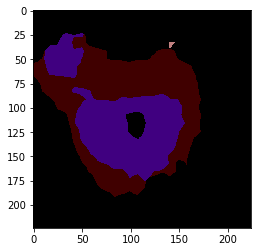

In [15]:
plt.imshow(y_image)

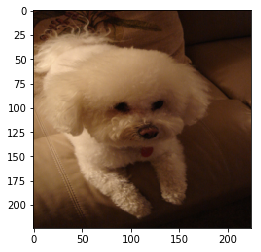

In [16]:
grid_img = torchvision.utils.make_grid(input_x[0], nrow=1)
imshow(grid_img)

## Implement Fully connected CRF

In [5]:
import pydensecrf.densecrf as densecrf
import pydensecrf.utils as utils

In [6]:
class FullyConnCRF(object):
    def __init__(self, iter_max, pos_w, pos_xy_std, bi_w, bi_xy_std, bi_rgb_std):
        self.iter_max = iter_max
        self.pos_w = pos_w
        self.pos_xy_std = pos_xy_std
        self.bi_w = bi_w
        self.bi_xy_std = bi_xy_std
        self.bi_rgb_std = bi_rgb_std
        
    def __call__(self, image, probmap):
        C, H, W = probmap.shape
        
        U = utils.unary_from_softmax(probmap)
        U = np.ascontiguousarray(U)
        
        image = np.ascontiguousarray(image)
        
        d = densecrf.DenseCRF2D(W, H, C)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=self.pos_xy_std, compat=self.pos_w)
        d.addPairwiseBilateral(sxy=self.bi_xy_std, srgb=self.bi_rgb_std, rgbim=image, compat=self.bi_w)
        
        Q = d.inference(self.iter_max)
        Q = np.array(Q).reshape((C, H, W))
        return Q

In [77]:
def preprocess_image(img):
    """
    Convert tensor image to numpy
    """
    img = torch.squeeze(img)
    img = img.cpu().numpy()
    img = img.transpose((1, 2, 0))
    print(img.min(), img.max())
    return img

input_image = preprocess_image(image)

TypeError: transpose(): argument 'dim0' (position 1) must be int, not tuple

In [40]:
def preprocess_output(img):
    img = torch.squeeze(img)
    img = torch.nn.LogSoftmax(dim=0)(img)
    img = img.cpu().numpy()
    img = -img
    return(img)
probmap = preprocess_output(output)

In [27]:
dense_crf = FullyConnCRF(iter_max=1,
                         pos_w=3,
                         pos_xy_std=1,
                         bi_w=4,
                         bi_xy_std=67,
                         bi_rgb_std=3)

In [68]:
segmap = dense_crf(img, probmap)

In [7]:
data_dir = '../../../../Data/Segmentation Data/train/'
x_dir = data_dir + 'Images/'

x_images = [x_dir + x for x in os.listdir(x_dir)]
x_images.sort()

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class PASCAL_VOC_eval(torch.utils.data.Dataset):
    def __init__(self, x_images, transform):
        self.x_images = x_images
        self.transform = transform
        
    def __len__(self):
        return len(self.x_images)
    
    def __getitem__(self, idx):
        image = io.imread(x_images[idx])
        raw_image = cv2.resize(image, (224, 224))
        image = self.transform(image)
        return (image, raw_image)
    
dataset = PASCAL_VOC_eval(x_images, data_transform)
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=8)


def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [35]:
x, r = next(iter(data_loader))
x = x.to(device)
out_img = model(x)

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 3.94 GiB total capacity; 2.78 GiB already allocated; 275.88 MiB free; 229.06 MiB cached)

In [51]:
out_segmap = out_img[2]
def preprocess_output(img):
    img = torch.nn.LogSoftmax(dim=0)(img)
    img = img.detach().cpu().numpy()
    img = -img
    c, h, w = img.shape
    temp = np.zeros((c+1, h, w))
    temp[1:] = img
    return temp
probmap = preprocess_output(out_segmap)
input_img = r[2].numpy()

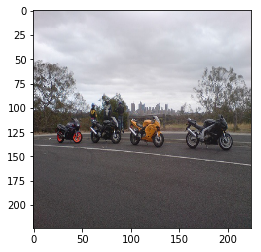

In [52]:
plt.imshow(input_img)

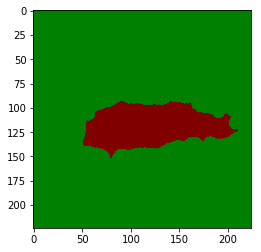

In [58]:
dense_crf = FullyConnCRF(iter_max=10,
                         pos_w=1,
                         pos_xy_std=1,
                         bi_w=1,
                         bi_xy_std=1,
                         bi_rgb_std=3)
segmap = dense_crf(input_img, probmap)

y = np.argmax(segmap, 0)
ans = decode_segmap(y)
plt.imshow(ans)

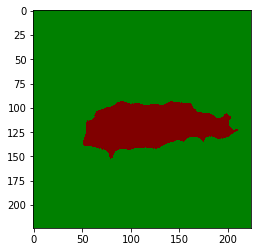